In [2]:
import gzip
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import random
import os

In [3]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

### Writing PyG Dataset

In [4]:
import torch

In [5]:
from torch_geometric.data import InMemoryDataset
from torch.utils.data import DataLoader

In [6]:
from torch_geometric.utils import from_networkx, to_networkx

In [7]:
def clustering_coefficient(G, node):
    ns = [n for n in G.neighbors(node)]
    if len(ns) <= 1:
        return 0
    
    numerator = 0
    denominator = len(ns) * (len(ns) - 1) / 2
    for i in range(0, len(ns)):
        for j in range(i+1, len(ns)):
            n1, n2 = ns[i], ns[j]
            numerator += G.has_edge(n1, n2)
    
    return numerator / denominator
                

In [8]:
def generate_feature_vector(G):
    x = torch.randn(G.number_of_nodes(), 4)
    ind = 0
    for node in G.nodes():
        x[ind][0] = 1 # uniform
        x[ind][1] = G.degree[node] # node degree as a scalar 
        x[ind][2] = clustering_coefficient(G, node) # triangle counting?
        x[ind][3] = ind # node ID features
        ind += 1
    return x

In [9]:
class LamanDataset(InMemoryDataset):
    def __init__(self, root, data_dir, transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data.pt']
        
    def process(self):
        total_laman_data = None
        with gzip.open(self.data_dir, 'r') as f:
            total_laman_data = pickle.load(f)
            
        data_list = []
        for ind, graph in enumerate(total_laman_dalta[0]):
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        for ind, graph in enumerate(total_laman_data[1]):
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [10]:
DATA_PATH = "data/lim1-4-output.pkl.gz"

In [11]:
import torch_geometric.transforms as T
laman_data = LamanDataset("", DATA_PATH)

In [40]:
laman_data[0]

Data(edge_index=[2, 74], x=[20, 4], label=[1], num_nodes=20)

## Split into Train / Test

In [13]:
from torch.utils.data import random_split

proportions = [.7, .3]
lengths = [int(p * len(laman_data)) for p in proportions]
lengths[-1] = len(laman_data) - sum(lengths[:-1])

generator1 = torch.Generator().manual_seed(42)
train_data, test_data = random_split(laman_data, lengths, generator=generator1)

In [14]:
print(type(train_data))

<class 'torch.utils.data.dataset.Subset'>


In [15]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle=True)

In [16]:
print("Number of train batches: ", len(train_loader))
print("Number of test batches: ", len(test_loader))

Number of train batches:  386
Number of test batches:  166


In [17]:
for data in train_loader:
    print(data)
    break

DataBatch(edge_index=[2, 4736], x=[1280, 4], label=[64], num_nodes=1280, batch=[1280], ptr=[65])


## Model Architecture & Training

In [18]:
from gin.gin_k_layers import GIN

In [38]:
# model = GIN(num_layers = 10, num_features=4, dim=4)
model = GIN(layers = 6, num_features=4, dim_h=7)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GIN(
  (conv_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=4, out_features=7, bias=True)
      (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=7, out_features=7, bias=True)
      (4): ReLU()
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=7, bias=True)
      (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=7, out_features=7, bias=True)
      (4): ReLU()
    ))
    (2): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=7, bias=True)
      (1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=7, out_features=7, bias=True)
      (4): ReLU()
    ))
    (3): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=7, bias=True)
      (1): BatchNor

In [20]:
from torch_geometric.data import DataLoader
from torch.nn import BCELoss
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.001)

# scheduler = ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6, verbose=True, patience=10)

In [21]:
def train(model, data, features_to_use):
    ind = 0
    for batch in data:
#         print(batch)
        optimizer.zero_grad()
        pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred.float(), batch.label.float())
        loss.backward()
        optimizer.step()
        ind += 1

    return loss, model

In [22]:
def check_accuracy(model, loader, features_to_use):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            y = batch.label
            batch.label = 0
            pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
            pred = torch.squeeze(pred)
            predictions = (pred > 0.5).long() 
            num_correct += (predictions == y).sum() 
            num_samples += predictions.size(0)
            
    return float(num_correct)/float(num_samples)*100

In [23]:
print("Starting training...")
losses = []

bestModel, highestAcc = None, 0

for epoch in range(600):
    loss, model = train(model, train_loader, [0, 1, 2, 3])
    losses.append(loss)
    print(f"Epoch {epoch} | Train loss {loss}")
    train_acc, test_acc = check_accuracy(model, train_loader, [0, 1, 2, 3]), check_accuracy(model, test_loader, [0, 1, 2, 3])
    print(f"Train Accuracy {train_acc} | Test Accuracy {test_acc}")
    
    if test_acc > highestAcc:
        highestAcc = test_acc
        bestModel = model

Starting training...
Epoch 0 | Train loss 0.5749751925468445
Train Accuracy 75.65495985075837 | Test Accuracy 75.78538985616957
Epoch 1 | Train loss 0.710007905960083
Train Accuracy 77.81247465325654 | Test Accuracy 78.01854655563967
Epoch 2 | Train loss 0.4121203124523163
Train Accuracy 76.76616108362397 | Test Accuracy 76.2112036336109
Epoch 3 | Train loss 0.41011834144592285
Train Accuracy 78.62762592262146 | Test Accuracy 78.29295987887964
Epoch 4 | Train loss 0.3282865285873413
Train Accuracy 78.7492902911834 | Test Accuracy 78.59576078728236
Epoch 5 | Train loss 0.2933710515499115
Train Accuracy 79.0210073809717 | Test Accuracy 78.52006056018168
Epoch 6 | Train loss 0.6611989140510559
Train Accuracy 79.483331981507 | Test Accuracy 79.26760030280091
Epoch 7 | Train loss 0.6330145597457886
Train Accuracy 79.66988401330197 | Test Accuracy 79.0783497350492
Epoch 8 | Train loss 0.753358781337738
Train Accuracy 79.45494362884257 | Test Accuracy 78.72823618470855
Epoch 9 | Train loss 0.

Epoch 76 | Train loss 0.4285810887813568
Train Accuracy 85.75310244139833 | Test Accuracy 82.88228614685845
Epoch 77 | Train loss 0.19862383604049683
Train Accuracy 84.50807040311462 | Test Accuracy 82.15367146101438
Epoch 78 | Train loss 0.17055997252464294
Train Accuracy 85.10422580906804 | Test Accuracy 82.89174867524602
Epoch 79 | Train loss 0.20737223327159882
Train Accuracy 85.03933814583502 | Test Accuracy 82.38077214231643
Epoch 80 | Train loss 0.4569436311721802
Train Accuracy 85.33538810933571 | Test Accuracy 82.68357305071915
Epoch 81 | Train loss 0.601449728012085
Train Accuracy 85.22994565658205 | Test Accuracy 82.50378501135503
Epoch 82 | Train loss 0.2894672155380249
Train Accuracy 85.5868278043637 | Test Accuracy 82.98637395912188
Epoch 83 | Train loss 0.385447233915329
Train Accuracy 84.59323546110795 | Test Accuracy 82.65518546555639
Epoch 84 | Train loss 0.47190040349960327
Train Accuracy 85.95993186795361 | Test Accuracy 82.81604844814534
Epoch 85 | Train loss 0.127

KeyboardInterrupt: 

In [ ]:
# analyze which kinds of graph it succeeds versus fails on

In [23]:
# look through the success and failure cases

In [43]:
correct, failed = [], []
num_rigid_wrong, num_flexible_wrong = 0, 0
num_rigid, num_flexible = 0, 0
for x in test_data:
    # convert from torch_geometric.data.data.Data to networkx graph?
    label = x.label[0]
    if label == 0:
        num_rigid += 1
    elif label == 1:
        num_flexible += 1
        
        
    model.eval()
    graph = to_networkx(x, to_undirected = True)
    validation_set = DataLoader([x], batch_size = 1, shuffle=True)
    for batch in validation_set:
        pred = bestModel(batch.x[:, [0, 1, 2, 3]], batch.edge_index, batch.batch)
        pred = pred[0][0][0]
        if pred > 0.5:
            pred = 1
        else:
            pred = 0
            
        if pred != label:
            failed.append((graph, label))
            if label == 1:
                num_flexible_wrong += 1
            if label == 0:
                num_rigid_wrong += 1
        else:
            correct.append((graph, label))    

In [44]:
print(num_rigid_wrong)
print(num_flexible_wrong)

1006
884


In [115]:
print(len(correct))

10184


In [ ]:
nx.draw(failed[1][0])

In [ ]:
failed[3][0].number_of_edges()

In [ ]:
from networkx.algorithms.isomorphism import subgraph_isomorphisms


In [ ]:
import networkx as nx

# Define the substructure you want to search for
substructures = {
    "triangle": triangle,
    "square": square, 
    "pentagon": pentagon,
}

substructures_freqs = {
    "triangle": 0,
    "square": 0,
    "pentagon": 0,
}


# Calculate the frequency of the substructure in each graph
substructure_freqs = []
for (graph, label) in failed:
    for substructure_name, substructure_graph in substructures.items():
        GM = nx.algorithms.isomorphism.GraphMatcher(graph,substructure_graph)
        gm_iterator = nx.algorithms.isomorphism.GraphMatcher.subgraph_isomorphisms_iter(graph, substructure_graph)
        for g in gm_iterator:
            print("hi")
        print(len(gm_iterator))
        if GM.subgraph_is_isomorphic():
            substructures_freqs[substructure_name] += 1

#         count = sum([1 for _ in nx.subgraph_isomorphisms(graph, substructure_graph)])

# Print the frequency of the substructure in each graph
print(substructures_freqs)


In [ ]:
GM = nx.algorithms.isomorphism.GraphMatcher(pentagon_new,pentagon)

In [ ]:
if GM.subgraph_is_isomorphic():
    print("hi")

In [45]:
# analyze degree sequence
failed_rigid_degree_sequences = []
failed_flexible_degree_sequences = []

failed_rigid_clustering = []
failed_flexible_clustering = []

for (graph, label) in failed:
    degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
    if label == 0:
        failed_rigid_degree_sequences.append(degree_sequence)
        failed_rigid_clustering.append(sorted(nx.clustering(graph).values()))
    elif label == 1:
        failed_flexible_degree_sequences.append(degree_sequence)
        failed_flexible_clustering.append(sorted(nx.clustering(graph).values()))
        
# analyze degree sequence
correct_rigid_degree_sequences = []
correct_flexible_degree_sequences = []

correct_rigid_clustering = []
correct_flexible_clustering = []

for (graph, label) in correct:
    degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
    if label == 0:
        correct_rigid_degree_sequences.append(degree_sequence)
        correct_rigid_clustering.append(sorted(nx.clustering(graph).values()))
    elif label == 1:
        correct_flexible_degree_sequences.append(degree_sequence)
        correct_flexible_clustering.append(sorted(nx.clustering(graph).values()))


In [69]:
for i in range(len(correct_rigid_degree_sequences)):
    sm = np.sum(correct_rigid_degree_sequences[i])

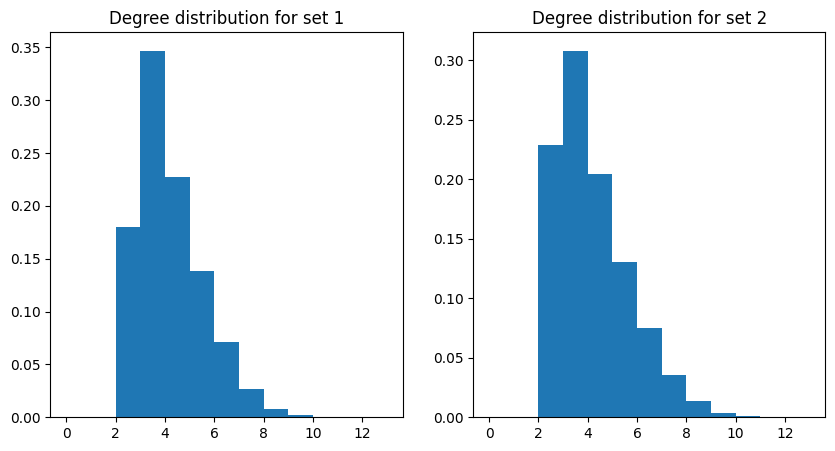

Mean degree for set 1: 3.7
Mean degree for set 2: 3.7
Standard deviation of degrees for set 1: 1.354980512586277
Standard deviation of degrees for set 2: 1.4923140176905516


In [46]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# # Generate two sets of graphs
# graphs1 = [correct[i][0] for i in range(len(correct))]
# graphs2 = [failed[i][0] for i in range(len(failed))] # List of NetworkX graphs

# Calculate degree sequences for each set of graphs
degree_seqs1 = correct_rigid_degree_sequences
degree_seqs2 = correct_flexible_degree_sequences

# Plot degree distribution for each set of graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(np.concatenate(degree_seqs1), bins=range(max(np.concatenate(degree_seqs1))+2), density=True)
ax1.set_title('Degree distribution for set 1')
ax2.hist(np.concatenate(degree_seqs2), bins=range(max(np.concatenate(degree_seqs2))+2), density=True)
ax2.set_title('Degree distribution for set 2')
plt.show()

# Compare mean and standard deviation of degree sequences
print("Mean degree for set 1:", np.mean(np.concatenate(degree_seqs1)))
print("Mean degree for set 2:", np.mean(np.concatenate(degree_seqs2)))
print("Standard deviation of degrees for set 1:", np.std(np.concatenate(degree_seqs1)))
print("Standard deviation of degrees for set 2:", np.std(np.concatenate(degree_seqs2)))


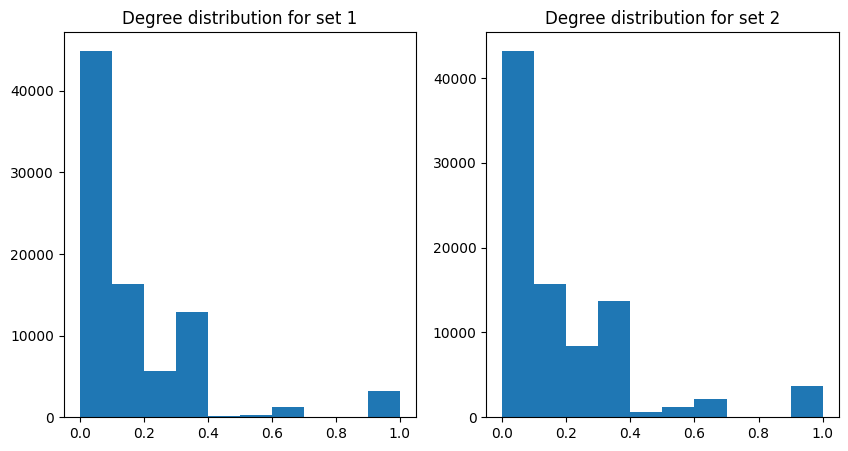

Mean degree for set 1: 0.1465492217212698
Mean degree for set 2: 0.16876047965563187
Standard deviation of degrees for set 1: 0.22252910399829934
Standard deviation of degrees for set 2: 0.23446350405271313


In [51]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# # Generate two sets of graphs
# graphs1 = [correct[i][0] for i in range(len(correct))]
# graphs2 = [failed[i][0] for i in range(len(failed))] # List of NetworkX graphs

# Calculate degree sequences for each set of graphs
degree_seqs1 = correct_rigid_clustering
degree_seqs2 = correct_flexible_clustering

# Plot degree distribution for each set of graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(np.concatenate(degree_seqs1))
ax1.set_title('Degree distribution for set 1')
ax2.hist(np.concatenate(degree_seqs2))
ax2.set_title('Degree distribution for set 2')
plt.show()

# Compare mean and standard deviation of degree sequences
print("Mean degree for set 1:", np.mean(np.concatenate(degree_seqs1)))
print("Mean degree for set 2:", np.mean(np.concatenate(degree_seqs2)))
print("Standard deviation of degrees for set 1:", np.std(np.concatenate(degree_seqs1)))
print("Standard deviation of degrees for set 2:", np.std(np.concatenate(degree_seqs2)))


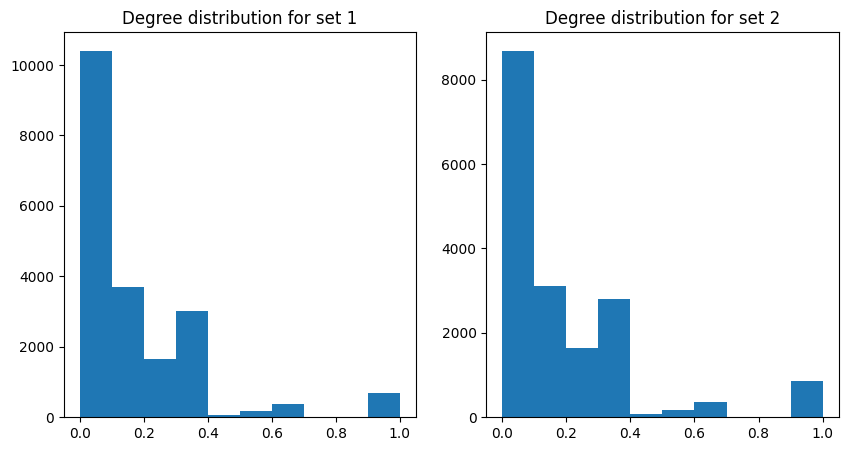

Mean degree for set 1: 0.15055830959409489
Mean degree for set 2: 0.16993125746802218
Standard deviation of degrees for set 1: 0.21992528958449525
Standard deviation of degrees for set 2: 0.2410804894342817


In [48]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# # Generate two sets of graphs
# graphs1 = [correct[i][0] for i in range(len(correct))]
# graphs2 = [failed[i][0] for i in range(len(failed))] # List of NetworkX graphs

# Calculate degree sequences for each set of graphs
degree_seqs1 = failed_rigid_clustering
degree_seqs2 = failed_flexible_clustering

# Plot degree distribution for each set of graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(np.concatenate(degree_seqs1))
ax1.set_title('Degree distribution for set 1')
ax2.hist(np.concatenate(degree_seqs2))
ax2.set_title('Degree distribution for set 2')
plt.show()

# Compare mean and standard deviation of degree sequences
print("Mean degree for set 1:", np.mean(np.concatenate(degree_seqs1)))
print("Mean degree for set 2:", np.mean(np.concatenate(degree_seqs2)))
print("Standard deviation of degrees for set 1:", np.std(np.concatenate(degree_seqs1)))
print("Standard deviation of degrees for set 2:", np.std(np.concatenate(degree_seqs2)))


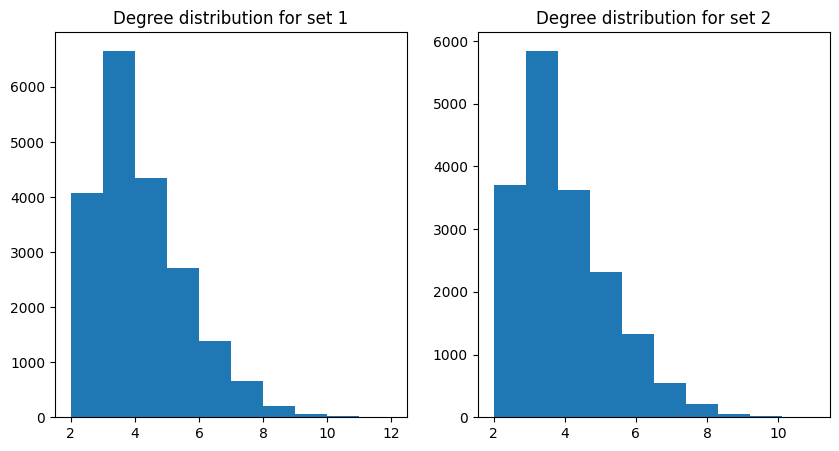

Mean degree for set 1: 3.7
Mean degree for set 2: 3.7
Standard deviation of degrees for set 1: 1.430761173219085
Standard deviation of degrees for set 2: 1.4588782649197307


In [50]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# # Generate two sets of graphs
# graphs1 = [correct[i][0] for i in range(len(correct))]
# graphs2 = [failed[i][0] for i in range(len(failed))] # List of NetworkX graphs

# Calculate degree sequences for each set of graphs
degree_seqs1 = failed_rigid_degree_sequences
degree_seqs2 = failed_flexible_degree_sequences

# Plot degree distribution for each set of graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(np.concatenate(degree_seqs1))
ax1.set_title('Degree distribution for set 1')
ax2.hist(np.concatenate(degree_seqs2))
ax2.set_title('Degree distribution for set 2')
plt.show()

# Compare mean and standard deviation of degree sequences
print("Mean degree for set 1:", np.mean(np.concatenate(degree_seqs1)))
print("Mean degree for set 2:", np.mean(np.concatenate(degree_seqs2)))
print("Standard deviation of degrees for set 1:", np.std(np.concatenate(degree_seqs1)))
print("Standard deviation of degrees for set 2:", np.std(np.concatenate(degree_seqs2)))


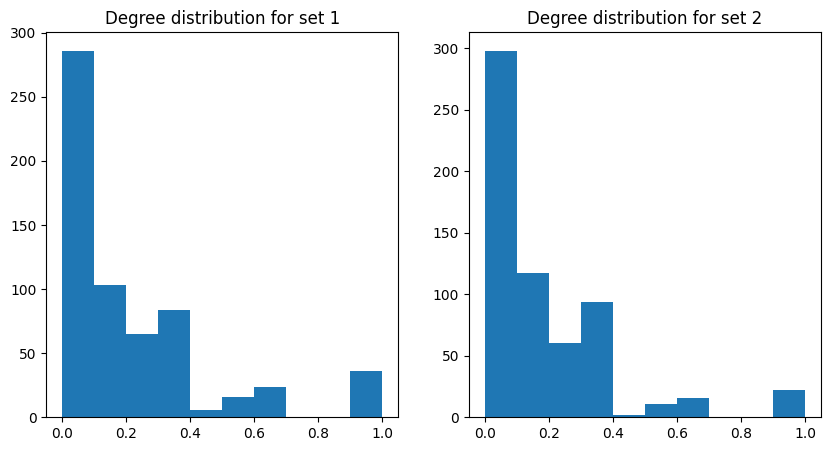

Mean clustering coefficient for set 1: 0.19740015360983104
Mean clustering coefficient for set 2: 0.16556707629288275
Standard deviation of degrees for set 1: 0.26405963091601253
Standard deviation of degrees for set 2: 0.2257134027741488


In [79]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# # Generate two sets of graphs
# graphs1 = [correct[i][0] for i in range(len(correct))]
# graphs2 = [failed[i][0] for i in range(len(failed))] # List of NetworkX graphs

# Calculate degree sequences for each set of graphs
degree_seqs1 = failed_flexible_clustering
degree_seqs2 = correct_flexible_clustering[10:10+len(failed_flexible_clustering)]

# Plot degree distribution for each set of graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(np.concatenate(degree_seqs1))
ax1.set_title('Degree distribution for set 1')
ax2.hist(np.concatenate(degree_seqs2))
ax2.set_title('Degree distribution for set 2')
plt.show()

# Compare mean and standard deviation of degree sequences
print("Mean clustering coefficient for set 1:", np.mean(np.concatenate(degree_seqs1)))
print("Mean clustering coefficient for set 2:", np.mean(np.concatenate(degree_seqs2)))
print("Standard deviation of degrees for set 1:", np.std(np.concatenate(degree_seqs1)))
print("Standard deviation of degrees for set 2:", np.std(np.concatenate(degree_seqs2)))


In [58]:
degree_seqs1 = failed_flexible_degree_sequences
degree_seqs2 = correct_flexible_degree_sequences[0:len(failed_flexible_degree_sequences)]

degree_seqs1_max = [max(seq) for seq in degree_seqs1]
degree_seqs2_max = [max(seq) for seq in degree_seqs2]

print(np.average(degree_seqs1_max))
print(np.average(degree_seqs2_max))

7.129032258064516
7.032258064516129


In [55]:
degree_seqs1_max

[7,
 8,
 7,
 7,
 6,
 8,
 7,
 6,
 6,
 6,
 7,
 8,
 7,
 7,
 7,
 6,
 7,
 6,
 8,
 8,
 6,
 6,
 7,
 8,
 7,
 6,
 9,
 8,
 9,
 8,
 8]

In [56]:
degree_seqs2_max

[7,
 7,
 9,
 8,
 7,
 6,
 7,
 6,
 7,
 6,
 8,
 9,
 8,
 7,
 6,
 10,
 8,
 6,
 7,
 6,
 7,
 6,
 7,
 6,
 8,
 7,
 6,
 6,
 7,
 6,
 7]

In [ ]:
# compute the degree sequence for each node and run an SVM?

In [36]:
print(len(correct_rigid_degree_sequences))
print(len(correct_flexible_degree_sequences))

660
657


In [122]:
ys = [0] * len(correct_rigid_clustering)

In [123]:
ys += [1] * len(correct_flexible_clustering)

In [124]:
Xs = correct_rigid_clustering + correct_flexible_clustering

In [130]:
Xs_degrees = correct_rigid_degree_sequences + correct_flexible_degree_sequences

In [136]:
Xs_nparr = np.array(Xs)
Xs_degrees_nparr = np.array(Xs_degrees)

print(Xs_nparr.shape)
print(Xs_degrees_nparr.shape)

concatenated_nparr = np.concatenate((Xs_nparr, Xs_degrees_nparr), axis=1)
print(concatenated_nparr.shape)

(10184, 20)
(10184, 20)
(10184, 40)


In [139]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assume X and y are your degree sequences and binary labels, respectively

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(concatenated_nparr, ys, test_size=0.2)

# Initialize the SVM classifier
clf = svm.SVC(kernel='linear')

# Fit the SVM classifier on the training data
clf.fit(X_train, y_train)

# Use the trained SVM classifier to make predictions on the testing data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.6116838487972509


In [ ]:
ys = [0] * len(correct_rigid_clustering)

In [ ]:
from sklearn.linear_model import LogisticRegression

# X is a matrix of features and y is a vector of labels
X = ...
y = ...

# Train a logistic regression model to predict y based on X
logreg = LogisticRegression().fit(X, y)

# Get the predicted labels for all data points
y_pred = logreg.predict(X)

# Find the indices of data points that are easily predictable (i.e., where the predicted label matches the true label)
easy_indices = [i for i in range(len(y)) if y[i] == y_pred[i]]

# Filter out the data points with easily predictable labels
X_filtered = np.delete(X, easy_indices, axis=0)
y_filtered = np.delete(y, easy_indices)


In [ ]:
failed[1][0].number_of_nodes()

In [ ]:
(failed[1][1])

In [ ]:
# look at how far the pebble game goes in those cases

In [ ]:
num_nodes = 50
model.eval()
for num_graphs in range(10):
    G = nx.erdos_renyi_graph(num_nodes, 0.2)
    graph_as_data = from_networkx(G)
    graph_as_data.x = generate_feature_vector(G)
    graph_as_data.label = 1
    validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
    for batch in validation_set:
        with torch.no_grad():
            pred = model(batch.x[:, [0, 1, 2, 3]], batch.edge_index, batch.batch)
            if (pred[0][0][0] < 0.5):
                print("WRONG")


In [ ]:
print(num_rigid)
print(num_flexible)

In [ ]:
g = nx.Graph()

In [ ]:
for i in range(0, 30):
    j = (np.random.randint(0, 30))
    while j == i:
        j = (np.random.randint(0, 30))
        
    print(j == i)
    g.add_edge(i, j)

In [ ]:
all_possible_edges = set()
for i in range(0, 30):
    for j in range(i+1, 30):
        if not g.has_edge(i, j):
            all_possible_edges.add((i,j))

In [ ]:
print(all_possible_edges)

In [ ]:
import random 
non_edges_sample_order = random.sample(all_possible_edges, 57 - 31)

In [ ]:
for (u,v) in non_edges_sample_order:
    g.add_edge(u, v)

In [ ]:
print(g.number_of_edges())

In [ ]:
model.eval()
with torch.no_grad():
    graph_as_data = from_networkx(g)
    graph_as_data.x = generate_feature_vector(g)
    validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
    for batch in validation_set:
        pred = model(batch.x[:, [0]], batch.edge_index, batch.batch)
        print(pred)


In [ ]:
check_accuracy(model, test_loader, [0])

In [ ]:
check_accuracy(model, train_loader, [0, 1, 2, 3])

In [ ]:
# sanity check

In [ ]:
# test on best model

In [80]:
# square
import networkx as nx
square = nx.Graph()
square.add_edge(0, 1)
square.add_edge(1, 3)
square.add_edge(0, 2)
square.add_edge(2, 3)

In [81]:
# square with cross bar (rigid)
import networkx as nx
square_bar = nx.Graph()
square_bar.add_edge(0, 1)
square_bar.add_edge(1, 3)
square_bar.add_edge(0, 2)
square_bar.add_edge(2, 3)
square_bar.add_edge(0, 3)
square_bar.add_edge(1, 2)

In [82]:
# triangle
import networkx as nx
triangle = nx.Graph()
triangle.add_edge(0, 1)
triangle.add_edge(0, 2)
triangle.add_edge(1, 2)

In [83]:
# pentagon
import networkx as nx
pentagon = nx.Graph()
pentagon.add_edge(0, 1)
pentagon.add_edge(1, 3)
pentagon.add_edge(3, 4)
pentagon.add_edge(4, 2)
pentagon.add_edge(2, 0)

In [84]:
# pentagon
import networkx as nx
pentagon_new = nx.Graph()
pentagon_new.add_edge(0, 1)
pentagon_new.add_edge(1, 3)
pentagon_new.add_edge(3, 4)
pentagon_new.add_edge(4, 2)
pentagon_new.add_edge(2, 0)
pentagon_new.add_edge(1, 2)

In [85]:
# no triangle and rigid
rigid = nx.Graph()
rigid.add_edge(0, 1)
rigid.add_edge(0, 2)
rigid.add_edge(0, 4)
rigid.add_edge(1, 2)
rigid.add_edge(1, 5)
rigid.add_edge(2, 3)
rigid.add_edge(3, 4)
rigid.add_edge(3, 5)
rigid.add_edge(4, 5)

In [86]:
# two triangles
two_triangles = nx.Graph()
two_triangles.add_edge(0, 1)
two_triangles.add_edge(0, 2)
two_triangles.add_edge(1, 2)
two_triangles.add_edge(2, 3)
two_triangles.add_edge(1, 3)

In [87]:
# three triangles
three_triangles = nx.Graph()
three_triangles.add_edge(0, 1)
three_triangles.add_edge(0, 2)
three_triangles.add_edge(1, 2)
three_triangles.add_edge(2, 3)
three_triangles.add_edge(1, 3)
three_triangles.add_edge(1, 4)
three_triangles.add_edge(3, 4)
three_triangles.add_edge(4, 2)
three_triangles.add_edge(0, 4)

In [88]:
toy_problems = [square, square_bar, triangle, pentagon, rigid, two_triangles, three_triangles]
labels = [1, 0, 0, 1, 0, 0, 1]

for index, toy_problem in enumerate(toy_problems):
    model.eval()
    with torch.no_grad():
        graph_as_data = from_networkx(toy_problem)
        graph_as_data.x = generate_feature_vector(toy_problem)
#         graph_as_data.label = labels[index]
        validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
        for batch in validation_set:
            pred = model(batch.x[:, [0, 1, 2,3]], batch.edge_index, batch.batch)
            print(pred)
    

(tensor([[1.]]), tensor([[35.8275]]))
(tensor([[0.1298]]), tensor([[-1.9025]]))
(tensor([[1.]]), tensor([[27.9102]]))
(tensor([[1.]]), tensor([[43.6293]]))
(tensor([[0.0719]]), tensor([[-2.5586]]))
(tensor([[1.]]), tensor([[49.0966]]))
(tensor([[0.0358]]), tensor([[-3.2941]]))


In [ ]:
graph_as_data

In [ ]:
# get the distribution of examples that it fails on

In [ ]:
validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)

In [ ]:
for batch in validation_set:
    pred = bestModel(batch.x, batch.edge_index, batch.batch)
    print(pred[0])
    print(pred[1])

In [ ]:
class LamanTestDataset(InMemoryDataset):
    def __init__(self, root, data_dir, transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data_test.pt']
        
    def process(self):
        # processing code here
        total_laman_data = None
        with gzip.open(self.data_dir, 'r') as f:
            total_laman_data = pickle.load(f)
            
        data_list = []
        ind = 0
        # convert from graph to Data object
        for graph in total_laman_data[0]:
#             print(ind)
            ind += 1
            num_nodes = nx.number_of_nodes(graph)
#             x = torch.randn(num_nodes, 1)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        ind = 0
        for graph in total_laman_data[1]:
#             print(ind)
            ind += 1
            num_nodes = nx.number_of_nodes(graph)
#             x = torch.randn(num_nodes, 64)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
# add functionality to support a test dataset
TEST_DATA_PATH = "data/actually_test_local_changes.pkl.gz"
laman_test_set = LamanTestDataset("", TEST_DATA_PATH)

In [ ]:
from torch_geometric.loader import DataLoader
laman_test_loader = DataLoader(laman_test_set, batch_size = 2, shuffle=True)

In [ ]:
random_test_acc = check_accuracy(model, laman_test_loader, [0, 1, 2, 3])
print(f"Accuracy {random_test_acc}")

In [ ]:
# generate statistics on the data

In [ ]:
# test the clustering coefficient

In [ ]:
clustering_coefficient(square, 0)

In [ ]:
clustering_coefficient(triangle, 0)

In [ ]:
clustering_coefficient(square_bar, 0)

In [ ]:
# generate graph correlating clustering coefficient to rigidity

In [ ]:
for item in train_data:
    item = to_networkx(item)
    print(type(item))
    
    break

In [ ]:
torch_geometric.utils.convert.to_networkx()

# Scratch Work: Sahil

In [ ]:
total_laman_data = None
with gzip.open(DATA_PATH, 'r') as f:
    total_laman_data = pickle.load(f)

In [ ]:
sample_graph = total_laman_data[0][0]

In [ ]:
print(type(sample_graph))

In [ ]:
to_data = from_networkx(sample_graph)
from_data = to_networkx(to_data, to_undirected = True)

In [ ]:
print(type(from_data))

In [ ]:
def compute_min_clustering_coefficient(G):
    min_coefficient = 1
    for node in G.nodes():
        min_coefficient = min(min_coefficient, clustering_coefficient(G, node))
        
    return min_coefficient

In [ ]:
for index, sample_graph in enumerate(train_data):
    label = sample_graph.label
    networkx_sample_graph = to_networkx(sample_graph, to_undirected = True)
    print(label, " ", index, " ", compute_min_clustering_coefficient(networkx_sample_graph))
    
    if index == 10:
        break

In [ ]:
print(compute_min_clustering_coefficient(from_data))

In [ ]:
compute_min_clustering_coefficient(triangle)

In [ ]:
# what if instead of training a gnn – you just trained on 

In [ ]:
# train a binary classifier on just the degrees of the nodes



In [ ]:
# train a binary classifier on just the triangle feature

In [ ]:
# train a binary classifier on the triangle features and the degree

In [ ]:
# train a network with just degree of the node 

In [ ]:
model_just_degree = GIN(num_features=1)
print(model_just_degree)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [ ]:
print("Starting training...")
losses = []

bestModel, highestAcc = None, 0

for epoch in range(1000):
    loss, h = train(train_loader, [0])
    losses.append(loss)
    print(f"Epoch {epoch} | Train loss {loss}")
    train_acc, test_acc = check_accuracy(model_just_degree, train_loader), check_accuracy(model_just_degree, test_loader)
    print(f"Train Accuracy {train_acc} | Test Accuracy {test_acc}")
#     scheduler.step(test_acc)
    
    if test_acc > highestAcc:
        highestAcc = test_acc
        bestModel = model

In [ ]:
generate_feature_vector(sample_graph)

In [ ]:
sample_graph.x[:, [0, 1]]

In [ ]:
proportions = [.6, .2, .2]
lengths = [int(p * len(laman_data)) for p in proportions]
lengths[-1] = len(laman_data) - sum(lengths[:-1])

generator1 = torch.Generator().manual_seed(42)
train_data_list, test_data_list, val_data_list = random_split(laman_data, lengths, generator=generator1)


In [ ]:
train_data_list

In [ ]:
train_loader = DataLoader(train_data_list, batch_size=2, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=2)
test_loader = DataLoader(test_data_list, batch_size=2)


In [ ]:
for data in train_loader:
    print(data)